# South African Language Identification

Drikus de Wet 







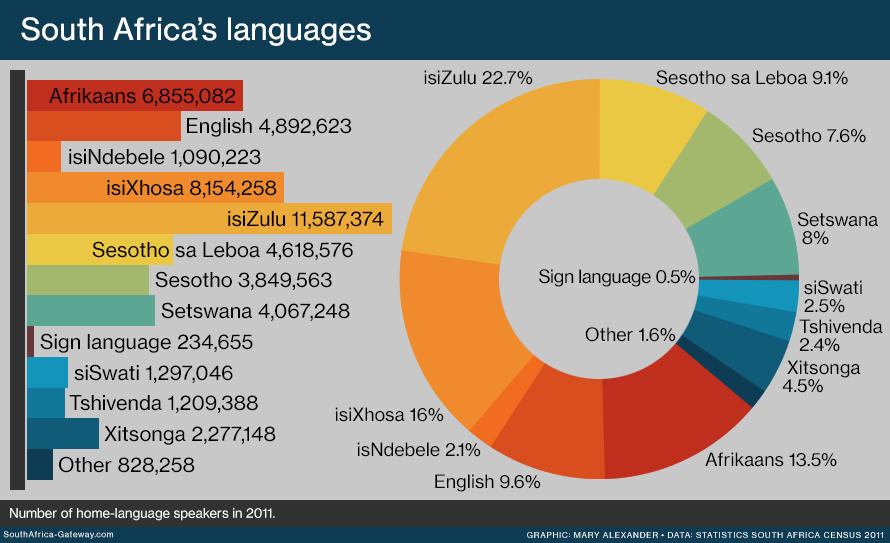







# Introduction

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages. With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

In this challenge, we will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.

# Goal

The aim of this modelling is to use NLP's Language Identification to classify a given text into one of the 11 Official South African Languages.

# Table of Contents

1. Importing Libraries
2. Importing Dataset
3. Data Preprocessing
4. Exploratory Data Analysis
5. Feature Engineering and Selection
6. Model Selection
7. Submission
8. Conclusion

# Importing Libraries

In [2]:
# Packages for data analysis
import pandas as pd
import numpy as np
import time

# Packages for visualizations
import seaborn as sns
import matplotlib.style as style

# Packages for preprocessing
import nltk
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Packages for training models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import xgboost as xgb

# Model Evaluation Packages
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
%matplotlib inline

# Style
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')


# Importing Dataset

In [3]:
# Importing the dataset
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# Data Preprocessing

In [4]:
# Looking at the first few entries in the dataset
train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [5]:
# Print the first few entries in the dataset
print(train['text'].head())

0    umgaqo-siseko wenza amalungiselelo kumaziko ax...
1    i-dha iya kuba nobulumko bokubeka umsebenzi na...
2    the province of kwazulu-natal department of tr...
3    o netefatša gore o ba file dilo ka moka tše le...
4    khomishini ya ndinganyiso ya mbeu yo ewa maana...
Name: text, dtype: object


In [6]:
# Looking at the first few entries in the dataset
test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [7]:
# Looking at the predicted output
sample_submission

,index,lang_id
0,1,tsn
1,2,nbl


In [8]:
# Looking at the how the text are distributed across the lang_id
train.describe()

,lang_id,text
count,33000,33000
unique,11,29948
top,xho,ngokwesekhtjheni yomthetho ophathelene nalokhu...
freq,3000,17


In [9]:
# Looking at the count values for each languange
train.lang_id.value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

In [10]:
# Looking at the numbers of possible language classes in our lang_id
train['lang_id'].unique()

array(['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso',
       'sot', 'afr'], dtype=object)

In [11]:
# Taking general overview at both datasets
print('TRAINING DATA')
print('============='+('\n'))
print('Shape of the dataset: {}\n'.format(train.shape))
print('Total Number of unique tweets: {}\n'.format(len(set(train['text']))))
print('Total Number of missing values:\n{}\n\n'.format(train.isnull().sum()))
print('TEST DATA')
print('========='+('\n'))
print('Shape of the dataset: {}\n'.format(test.shape))
print('Total Number of unique tweets: {}\n'.format(len(set(test['text']))))
print('Total Number of missing values:\n{}\n' .format(test.isnull().sum()))


TRAINING DATA

Shape of the dataset: (33000, 2)

Total Number of unique tweets: 29948

Total Number of missing values:
lang_id    0
text       0
dtype: int64


TEST DATA

Shape of the dataset: (5682, 2)

Total Number of unique tweets: 5459

Total Number of missing values:
index    0
text     0
dtype: int64



# Exploratory Data Analysis

In [12]:
# Checking whether a character is white-space character or not
print(len(train['text']))
print(sum(train['text'].apply(lambda x: x.isspace())))

33000
0


Text(0.5, 1.0, 'Distribution of target labels')

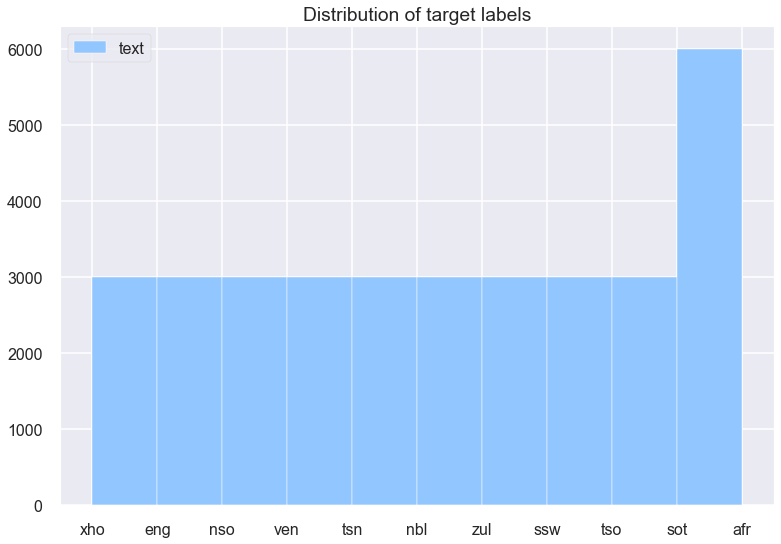

In [13]:
# Visualizing the distribution of the target 
plt.hist(train['lang_id'], label='text');
plt.legend();
plt.title('Distribution of target labels')

## Data Cleaning

In [14]:
def clean_text(text):
    """
    This function uses regular expressions to remove html characters,
    punctuation, numbers and any extra white space from each text
    and then converts them to lowercase.

    Input:
    text: original text
          datatype: string

    Output:
    texts: modified text
           datatype: string
    """
    # replace the html characters with " "
    text=re.sub('<.*?>', ' ', text)
#    Removal of numbers
#    text = re.sub(r'\d+', ' ', text)
    # will replace newline with space
    text = re.sub("\n"," ",text)
    # will convert to lower case
    text = text.lower()
    # will split and join the words
    text=' '.join(text.split())
    
    return text

In [15]:
# Application of the function to clean the tweets
train['text'] = train['text'].apply(clean_text)
test['text'] = test['text'].apply(clean_text)


In [16]:
# Replace '.txt' with 'text file'
train["text"] = train["text"].str.replace(".txt", " text file")
test["text"] = test["text"].str.replace(".txt", " text file")


<ipython-input-16-6b597cefd955>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train["text"] = train["text"].str.replace(".txt", " text file")
<ipython-input-16-6b597cefd955>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test["text"] = test["text"].str.replace(".txt", " text file")


# Feature Engineering and Selection

In [17]:
# Splitting out X (indepedent) and Y (target/dependent) variables
X = train['text']
y = train['lang_id']

In [18]:
# Splitting of Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# Model Selection

## Setting up Classifiers for Model Training

In [19]:
# List all the models

classifiers = [LinearSVC(random_state=42),
                SVC(),
                DecisionTreeClassifier(),
                RandomForestClassifier(n_estimators=100, max_depth=2,
                                     random_state=0, class_weight="balanced"),
                MLPClassifier(alpha=1e-5,
                             hidden_layer_sizes=(5, 2),
                             random_state=42),
                LogisticRegression(random_state=42,
                                  multi_class='ovr',
                                  n_jobs=1,
                                  C=1e5,
                                  max_iter=4000),
                KNeighborsClassifier(n_neighbors=5),
                MultinomialNB(),
                ComplementNB(),
                SGDClassifier(loss='hinge',
                             penalty='l2',
                             alpha=1e-3,
                             random_state=42,
                             max_iter=5,
                             tol=None)
               ]


In [20]:
# Creating Function for Model Building

def models_building(classifiers, X_train, y_train, X_val, y_val):
    """
    This function takes in a list of classifiers
    and both the train and validation sets
    and return a summary of F1-score and
    processing time as a dataframe

    Input:
    classifiers: a list of classifiers to train
                 datatype: list
    X_train: independent variable for training
             datatype: series
    y_train: dependent variable for training
             datatype: series
    X_val: independent variable for validation
           datatype: series
    y_val: dependent variable for validation
           datatype: series

    Output:
    model_summary: F1 Score for all the classifiers
                   datatype: dataframe
    """

    models_summary = {}

    # Pipeline to balance the classses and then to build the model
    for clf in classifiers:
        clf_text = Pipeline([('tfidf', TfidfVectorizer(min_df=1,
                                                       max_df=0.9,
                                                       ngram_range=(3, 6),
                                                       analyzer='char')),
                             ('clf', clf)])

        # Logging the Execution Time for each model
        start_time = time.time()
        clf_text.fit(X_train, y_train)
        predictions = clf_text.predict(X_val)
        run_time = time.time()-start_time

        # Output for each model
        models_summary[clf.__class__.__name__] = {
            'F1-Macro': metrics.f1_score(y_val,
                                         predictions,
                                         average='macro'),
            'F1-Accuracy': metrics.f1_score(y_val, predictions,
                                            average='micro'),
            'F1-Weighted': metrics.f1_score(y_val,
                                            predictions,
                                            average='weighted'),
            'Execution Time': run_time}

    return pd.DataFrame.from_dict(models_summary, orient='index')


In [ ]:
# Execution of the Classifiers

classifiers_df = models_building(classifiers, X_train, y_train, X_val, y_val)
ordered_df = classifiers_df.sort_values('F1-Macro', ascending=False)
ordered_df


### Comparing Classification Methods

The most performing is the Multinomial Naive Bayes with F1-Macro of 99.9% and accuracy of 99.9% while closely followed by Complement Naive Bayes, Logistic Regression, Linear Support Vector Classifier, Support Vector Machine etc.

We will proceed with the first two algorithms (to see which will come out better) by applying hyperparameter tunining, as they are the most performing models and considering their execution time.

## Hyperparameter Tuning on Most Performing Models

In [ ]:
# Refining the train-test split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20)

### Multinomial Naive Bayes

In [ ]:
# Creating a pipeline for the gridsearch
param_grid = {'alpha': [0.1, 1, 5, 10]}  # setting parameter grid

HP_MNB = Pipeline([('tfidf', TfidfVectorizer(min_df=2,
                                                max_df=0.9,
                                                ngram_range=(3, 6),
                                                analyzer='char')),
                      ('mnb', GridSearchCV(MultinomialNB(),
                                           param_grid=param_grid,
                                           cv=5,
                                           n_jobs=-1,
                                           scoring='f1_weighted'))
                      ])

HP_MNB.fit(X_train, y_train)  # Fitting the model

y_pred_mnb = HP_MNB.predict(X_val)  # predicting the fit on validation set

print(classification_report(y_val, y_pred_mnb, digits = 5))


# Submission

In [ ]:
submission = pd.DataFrame(test['index'])
submission['lang_id'] = HP_MNB.predict(test['text'])
submission.to_csv('DDW.csv', index=False)


In [ ]:
submission

# 6. Conclusion

Several algorithms were tried and Multinomial Naive Bayes classifier was the most performing. It performed very well on the training and validation datasets with an accuracy score of over 99% and F1 Macro score of over 99%. After testing the fitted model on the held-out/unseen dataset, it was able to predict the classes of languages with an F1 Score of about 97%.